# Run SHAP for each model

In [1]:
root="../../.."

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from joblib import load, dump
shap.initjs()

model_name = 'kegg'
gdbt_model = load("%s/codes/AI/model/GDBT_%s.joblib"%(root, model_name))
data = pd.read_csv("%s/codes/AI/output/cross_validation/full_model/input/%s.csv"%(root, model_name), 
                   index_col=0).transpose()

X = data
model = gdbt_model
explainer = shap.TreeExplainer(model)
#shap_values = explainer(X)
#shap_values.values = shap_values.values.reshape(shap_values.data.shape)
#shap_values.base_values = shap_values.base_values.reshape(shap_values.data.shape[0],)
#result = {'explainer':explainer, 'shap_values': shap_values}
#dump(result, '%s/codes/AI/output/shap/%s_gdbt.pkl'%(model_name))

2024-01-18 22:44:54.855482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 22:44:57.707548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
import sys
input_value = sys.argv[1]

import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from joblib import load, dump
shap.initjs()

model_name = input_value
model = tf.keras.models.load_model("%s/codes/AI/model/DNN_%s"%(root, model_name))
data = pd.read_csv("%s/codes/AI/output/cross_validation/full_model/input/%s.csv"%(root, model_name), 
                   index_col=0).transpose()

X = data
explainer = shap.KernelExplainer(model.predict, data = X)
#shap_values = explainer(X)

shap_values.values = shap_values.values.reshape(shap_values.data.shape)
shap_values.base_values = shap_values.base_values.reshape(shap_values.data.shape[0],)
#dump(shap_values, '%s/codes/AI/output/shap/%s_DNN.pkl'%(root, model_name))

#python dnn.py "$input_value"

In [ ]:
import sys

model_name = sys.argv[1]
score_index = int(sys.argv[2])
print("Model Name:", model_name)
print("Score:", score_index)

import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from joblib import load, dump
from sklearn.preprocessing import StandardScaler
shap.initjs()

model_full = tf.keras.models.load_model("%s/codes/AI/model/DNN_score_%s"%(root, model_name))
data = pd.read_csv("%s/codes/AI/output/cross_validation/full_model/input/%s.csv"%(root, model_name), index_col=0).transpose()

shared_layer_index = range(0,8)
dense_layer_name = ["dense_%s" %(i) for i in list(range(2, 14))]
out_layer_name = ["out%s" %(i) for i in list(range(0, 12))]

dense_name = dense_layer_name[score_index]
out_name = out_layer_name[score_index]
model = tf.keras.models.Sequential(model_full.layers[:8])
model.add(model_full.get_layer(dense_name))
model.add(model_full.get_layer(out_name))

X = StandardScaler().fit_transform(data)
explainer = shap.KernelExplainer(model = model.predict, data = X)
#shap_values = explainer.shap_values(X = X)

# shap value for catagorical features, used the control catagory for the feature importance
expected_value = explainer.expected_value
if len(expected_value) == 1:
    shap_values = shap.Explanation(values = shap_values[0], 
                 base_values=list(explainer.expected_value) * X.shape[0],
                 data=X, feature_names = data.columns)
else:
    shap_values = shap.Explanation(values = shap_values, 
                 base_values=np.tile(explainer.expected_value, (X.shape[0], 1)),
                 data=X, feature_names = data.columns)

#dump(shap_values, '%s/codes/AI/output/shap/%s_score_%s.pkl'%(root, model_name, score_index))

#python dnn.py $model_name $score_index

---
# Based on the SHAP results, generate the Omics matrix

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import shap
shap.initjs()

from joblib import load, dump
import pickle

2024-01-22 17:49:58.024078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 17:49:59.976299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
choose_list = ['immune_score_0', 'immune_score_1', 'immune_score_2', 'metabolome_score_3', 'metabolome_score_4', 
               'immune_score_5', 'immune_score_6', 'immune_score_7', 'specie_score_8', 'kegg_score_9', 
               'immune_score_10','specie_score_11']

In [4]:
best_n = 30
feature_list = []
for i in choose_list:
    shap_values = load("../output/shap/%s.pkl"%(i))
    if len(shap_values.values)==4 or len(shap_values.values)==5: 
        shap_data = pd.DataFrame(shap_values.values[0], columns = shap_values.feature_names)
    else:
        shap_data = pd.DataFrame(shap_values.values, columns = shap_values.feature_names)
    top_features = shap_data.abs().sum().nlargest(best_n).index.to_list()
    feature_list.append(top_features)
feature_list = [item for sublist in feature_list for item in sublist]
feature_list = list(set(feature_list))
all_omics = pd.read_csv("%s/codes/AI/input/omics.csv"%(root), index_col=0)
#all_omics.loc[feature_list,:].to_csv("%s/codes/AI/input/omics.csv"%(root))

---
# Now plotting
# By Omics: the shared top feature for each omics, disease specific biomarkers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import shap
shap.initjs()

from joblib import load, dump
import pickle

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ranksums

input_dir = "%s/codes/AI/output/cross_validation/full_model/input"%(root)

2024-01-27 19:02:14.546264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 19:02:16.083779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
def bee_swarm_shap(shap_obj, ax):
    shap_data = shap_obj.values
    orig_data = shap_obj.data
    X = orig_data
    X = MinMaxScaler().fit_transform(X)
    orig_data = pd.DataFrame(X, index = orig_data.index, columns=orig_data.columns)
    shap_data = pd.DataFrame(shap_data, index = orig_data.index, columns=orig_data.columns)
    melted_orig_data = pd.melt(orig_data, value_vars=orig_data.columns, var_name='feature', value_name='color')
    melted_shap_data = pd.melt(shap_data, value_vars=shap_data.columns, var_name='feature', value_name='shap_value') 
    melted_df = pd.concat([melted_shap_data, melted_orig_data['color']], axis=1)
    sns.stripplot(x='feature', y='shap_value', hue='color', data=melted_df, palette=shap.plots.colors.red_blue,
                  jitter=True, edgecolor='none', size = 3, ax = ax, legend=None)

In [4]:
def write_omics_summary(omics_name, best_n):
    omics_summary = dict()
    metadata = pd.read_csv("%s/codes/AI/input/metadata.csv"%(root), index_col=0)
    scores = pd.read_csv("%s/codes/AI/input/score.csv"%(root), index_col=0)
    best_n = best_n
    feature_list = []
    for i in range(12):
        shap_values = load("%s/codes/AI/output/shap/%s_score_%s.pkl"%(root,omics_name,i))
        if len(shap_values.values)==4 or len(shap_values.values)==5: 
            shap_data = pd.DataFrame(shap_values.values[0], columns = shap_values.feature_names)
        else:
            shap_data = pd.DataFrame(shap_values.values, columns = shap_values.feature_names)
        top_features = shap_data.abs().sum().nlargest(best_n).index.to_list()
        feature_list.append(top_features)
    feature_list = [item for sublist in feature_list for item in sublist]
    feature_list_abundance = pd.Series(feature_list).value_counts()
    feature_list = feature_list_abundance.index[feature_list_abundance > 9]
    feature_list = feature_list[:10]
    #feature_list = feature_list_abundance.index
    omics_data = pd.read_csv("%s/codes/AI/input/%s.csv"%(root,omics_name), 
                         index_col=0).transpose()
    X = StandardScaler().fit_transform(omics_data)
    omics_data = pd.DataFrame(X, index=omics_data.index, columns=omics_data.columns)
    
    scores_shap = pd.DataFrame(0, index=scores.columns, columns=omics_data.columns)
    scores_shap_rank = pd.DataFrame(0, index=scores.columns, columns=omics_data.columns)
    for i in range(12):
        shap_values = load("%s/codes/AI/output/shap/%s_score_%s.pkl"%(root,omics_name, i))
        if len(shap_values.values)==4 or len(shap_values.values)==5: 
            shap_data = pd.DataFrame(shap_values.values[0], columns = shap_values.feature_names)
        else:
            shap_data = pd.DataFrame(shap_values.values, columns = shap_values.feature_names)
        feature_imp = shap_data.abs().sum()
        feature_rank = shap_data.abs().sum().rank(ascending=False)
        scores_shap.iloc[i,:] = feature_imp
        scores_shap_rank.iloc[i,:] = feature_rank

    X = scores_shap
    X = MinMaxScaler().fit_transform(X.transpose())
    scores_shap = pd.DataFrame(X.T, index=scores_shap.index, columns=scores_shap.columns)
    scores_shap.to_csv("%s/codes/AI/output/shap/Scores_Normalized_SHAP_%s.csv"%(root, model_name))
    scores_shap = scores_shap.loc[:,feature_list]
    scores_shap = scores_shap.loc[:,scores_shap.sum().sort_values(ascending=False).index]
    
    omics_summary['scores_shap'] = scores_shap
    
    feature_list = scores_shap.columns.to_list()
    omics_summary['feature_list'] = feature_list
    scores_shap_rank = scores_shap_rank.loc[:,feature_list]
    scores_shap_rank = scores_shap_rank.transpose()
    scores_shap_rank.loc[:,'feature'] = scores_shap_rank.index
    omics_summary['scores_shap_rank'] = scores_shap_rank

    gdbt = load("%s/codes/AI/model/GDBT_%s.joblib"%(root,omics_name))
    gdbt_imp = pd.Series(gdbt.feature_importances_, index=omics_data.columns).sort_values(ascending=False)
    omics_summary['gdbt_imp'] = gdbt_imp[feature_list]
    
    shap_values = load("%s/codes/AI/output/shap/%s_DNN_shap_values.pkl"%(root,omics_name))
    dnn_selected = [shap_values.feature_names.index(i) for i in feature_list]
    shap_values.values = shap_values.values[:,dnn_selected]
    shap_values.data = shap_values.data.loc[:,feature_list]
    omics_summary['dnn_shap'] = shap_values
    
    
    omics_merge = pd.concat([metadata.loc[omics_data.index,['study_ptorhc','illness_duration']], 
                         omics_data],axis=1)
    data_stats = omics_merge.groupby(['study_ptorhc']).mean()
    
    data_stats.loc['p-value',:] = 1
    for feature in data_stats.columns:
        group_a = omics_data.loc[omics_merge['study_ptorhc'] == 'Control',feature]
        group_b = omics_data.loc[omics_merge['study_ptorhc'] == 'MECFS',feature]
        statistic, p_value = ranksums(group_a, group_b)
        data_stats.loc['p-value', feature] = p_value
    data_stats.loc['p-value' :] = multipletests(data_stats.loc['p-value',:], method='fdr_bh')[1]
    
    omics_summary['data_stats'] = data_stats.loc[:,feature_list]
    omics_summary['omics_data'] = omics_data.loc[:,feature_list]
    
    table = omics_summary['scores_shap'].copy()
    table.loc['GDBT',feature_list] = omics_summary['gdbt_imp']
    table.loc['DNN',feature_list] = omics_summary['dnn_shap'].values.mean(axis=0)
    table = pd.concat([table, omics_summary['data_stats']], axis =0)
    omics_summary['supplemental'] = table
    
    return(omics_summary)

In [5]:
def feature_name_adjust(feature,model_name='immune'):
    if model_name == 'quest': feature_new = feature
    if model_name == 'specie': 
        feature_new = feature.replace("_", " ").title()   
    if model_name == 'kegg': 
        meta = pd.read_csv("%s/data/metagenomics/KEGG_decode.csv"%(root),index_col=0)
        feature_new = meta.loc[feature,'Orthology'].split(";")[0]
        if feature != feature_new: feature_new = "%s; %s"%(feature, feature_new)
    if model_name == 'immune':
        feature_new = feature.replace("RO+","M").replace("RO-","")
        feature_new = feature_new.replace("d0","").replace("d6","").replace("d1","")
        feature_new = feature_new.replace("%","").replace(" ","")
    if  model_name == 'metabolome':
        feature_new = feature.split("/")[0].split("(")[0]
    return feature_new

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will

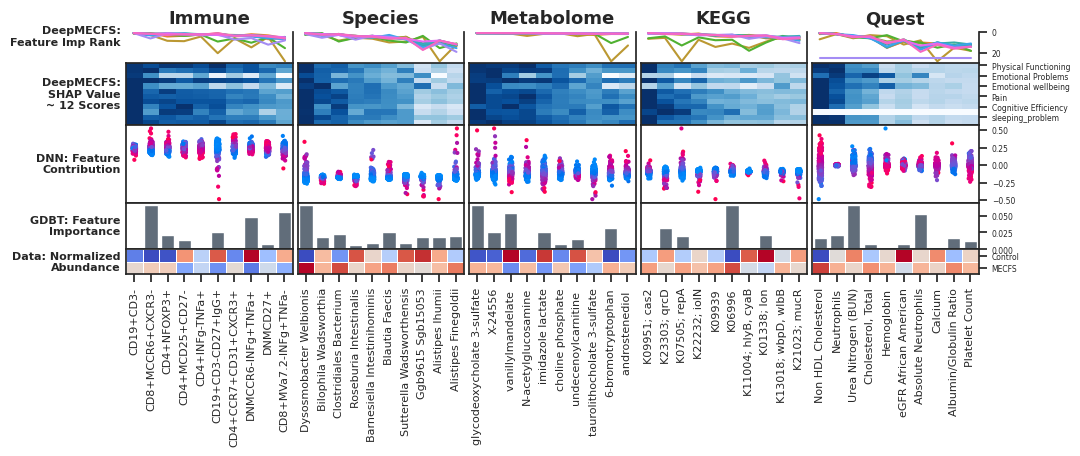

In [6]:
omics_list = ['immune','specie','metabolome','kegg','quest']
omics_name_dict = dict(zip(omics_list,['Immune','Species','Metabolome','KEGG','Quest']))

sns.set(style='ticks', font_scale=0.5, font='sans-serif')

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(11, 3.15),
                        gridspec_kw={'height_ratios': [0.1, 0.2, 0.25, 0.15, 0.08],
                                     'width_ratios': [1,1,1,1,1],
                                    'wspace': 0.03,'hspace': 0})
supplemental_list = []
# Iterate over each column (figure)
for i in range(len(omics_list)):
    model_name = omics_list[i]
    omics_summary = write_omics_summary(model_name, 20)
    supplemental_list.append(omics_summary['supplemental'])
    feature_names = omics_summary['feature_list']
    feature_names = [feature_name_adjust(i, model_name) for i in feature_names]
    
    # plot 1: Line plot of rank
    ax_now = axs[0, i]
    sns.lineplot(x='feature', y='value', hue='variable', ax=ax_now,
                 data=pd.melt(omics_summary['scores_shap_rank'], ['feature']), legend=False)
    ax_now.invert_yaxis()
    ax_now.set_xticks([])
    ax_now.set_xlabel(None)
    ax_now.set_ylabel(None)
    for spine in ax_now.spines.values(): spine.set_visible(False)
    ax_now.spines['right'].set_visible(True)
    ax_now.set_title(omics_name_dict[model_name], fontsize=13, fontweight='bold')
    if i < 4 : ax_now.set_yticks([])
    if i == 4: ax_now.yaxis.tick_right()    
    if i == 0: ax_now.set_ylabel("DeepMECFS:\nFeature Imp Rank", 
                                 fontsize=8, fontweight='bold', rotation=0,ha='right',va='bottom')

    # Plot 2: Heatmap 1: the averaged importance of shap in 12 scores
    ax_now = axs[1, i]
    data_now = omics_summary['scores_shap']
    data_now_index = list(data_now.index)
    data_now.index = [i.split(".")[1].replace("Role Limitations due to ","") for i in data_now_index]
    sns.heatmap(data_now, ax=ax_now, cmap='Blues', cbar=False, square=False)
    ax_now.set_xticks([])
    for spine in ax_now.spines.values(): spine.set_visible(True)
    if i < 4 : ax_now.set_yticks([])
    if i == 4: 
        ax_now.yaxis.tick_right()
        ax_now.yaxis.set_tick_params(rotation=360)
    if i == 0: ax_now.set_ylabel("DeepMECFS:\nSHAP Value\n ~ 12 Scores", 
                                 fontsize=8, fontweight='bold', rotation=0, ha='right',va='center')
        
    # Plot 3: Bee swarm plot: the Feature contribution in DNN model
    ax_now = axs[2, i]
    data_now = omics_summary['dnn_shap']
    bee_swarm_shap(data_now, ax_now)
    ax_now.set_xticks([])
    ax_now.set_xlabel(None)
    ax_now.set_ylabel(None)
    if i < 4 : ax_now.set_yticks([])
    if i == 4: ax_now.yaxis.tick_right()
    if i == 0: ax_now.set_ylabel("DNN: Feature\nContribution", 
                                 fontsize=8, fontweight='bold', rotation=0,ha='right',va='center')

    # Plot 4: Bar plot: the Feature importance in GDBT
    ax_now = axs[3, i]
    data_now = omics_summary['gdbt_imp']
    sns.barplot(x=data_now.index, y=data_now, ax=ax_now, color='#5D6D7E')
    ax_now.set_xticks([])
    if i < 4 : ax_now.set_yticks([])
    if i == 4: ax_now.yaxis.tick_right()    
    if i == 0: ax_now.set_ylabel("GDBT: Feature\nImportance", 
                                 fontsize=8, fontweight='bold', rotation=0,
                                 ha='right',va='center')
        
    
    # Plot 5: The DATA: normalized feature abundance in Control vs MECFS
    ax_now = axs[4, i]
    data_now = omics_summary['data_stats'].loc[['Control','MECFS'], :]
    sns.heatmap(data_now, ax=ax_now, cmap='coolwarm', linewidths=0.5,
                linecolor='white', cbar=False, square=False)
    ax_now.set_ylabel(None)
    for spine in ax_now.spines.values(): spine.set_visible(True)
    if i < 4 : ax_now.set_yticks([])
    if i == 4: 
        ax_now.yaxis.tick_right()  
        ax_now.yaxis.set_tick_params(rotation=360)
    if i == 0: ax_now.set_ylabel("Data: Normalized\nAbundance", 
                                 fontsize=8, fontweight='bold', rotation=0,ha='right',va='center')
    ax_now.set_xticklabels(feature_names, fontsize = 8, rotation=90, ha='center')
        
plt.tight_layout()
plt.savefig("%s/output/AI_figure/Biomarker_Disease.pdf"%(root), dpi=1000, bbox_inches='tight',transparent=True)
pd.concat(supplemental_list, 
          axis=1, keys=omics_list).to_csv("%s/output/AI_figure/Biomarker_Disease_importance.csv"%(root))